In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt

# inline magic changes figsize, set it again here
import matplotlib
matplotlib.rcParams['figure.figsize'] = 8,6 
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color'] # get default colors

from astropy.table import Table
from astropy.io import ascii

import pathos.multiprocessing as mp

# 1. Cube Making
This notebook generates likelihood cubes.



## 1.0. Loading Files from the Table
This function takes in a row of the `parameters.table` file, which specifies a combination of cosmological parameters and associated filenames. It then reads the relevant numpy array, looping over each redshift and appending.

Possible redshift strings are '05', '10', '15', '20', and '25', corresponding to actual redshifts 0.5, 1.0, 1.5, 2.0, and 2.5 respectively. The output is a table with each row being a realization, and each column as a data bin for either the power spectrum or peak counts. For each additional redshift in the list, you have to provide an l_min, l_max, kappa_min, and kappa_max.

In [3]:
# read in the output of notebook 0.
table = ascii.read('parameters.table')

In [4]:
def get_PS_and_PC_arrays(row, PS_directory, PC_directory, 
                         redshift_list=['10'],
                         l_min_list=[200], 
                         l_max_list=[5000], 
                         kappa_min_list=[-0.05], 
                         kappa_max_list=[np.inf]):
    
    # generate a list of files to read by replacing the z05
    PS_filenames = [ row['PS'].replace('05.npy', r+'.npy') \
                    for r in redshift_list ]
    PC_filenames = [ row['PC'].replace('05.npy', r+'.npy') \
                    for r in redshift_list ]

    # loop over redshifts and append them to a list
    PS_arr = []
    PC_arr = []
    for z_ind, redshift  in enumerate(redshift_list):
        # the following code is not very pythonic but more readable in my opinion
        l_min = l_min_list[z_ind]
        l_max = l_max_list[z_ind]
        kappa_min = kappa_min_list[z_ind]
        kappa_max = kappa_max_list[z_ind]
        PS_temp = np.load( PS_directory + r'/' + PS_filenames[z_ind] )
        PC_temp = np.load( PC_directory + r'/' + PC_filenames[z_ind] )

        # now filter for ell and kappa
        ell = PS_temp[0,:]
        kappa = PC_temp[0,:]
        ell_filter = np.logical_and( ell > l_min, ell < l_max )
        kappa_filter = np.logical_and( kappa > kappa_min, kappa < kappa_max )

        PS_arr.append( ((PS_temp.T)[ell_filter]).T )
        PC_arr.append( ((PC_temp.T)[kappa_filter]).T )

    # now stack them together sideways
    PS_arr = np.hstack(PS_arr)
    PC_arr = np.hstack(PC_arr)
    
    # first row of PS_arr is ell
    ell = PS_arr[0,:]
    PS_realizations = PS_arr[1:,:]
    # first and second row of PC are kappa, SNR
    kappa = PC_arr[0,:]
    PC_realizations = PC_arr[2:,:]
    
    return ell, PS_realizations, kappa, PC_realizations

### A Demonstration of the Noisy Spectra
We can load the first row (the fiducial model) and plot all 1000 peak count realizations.

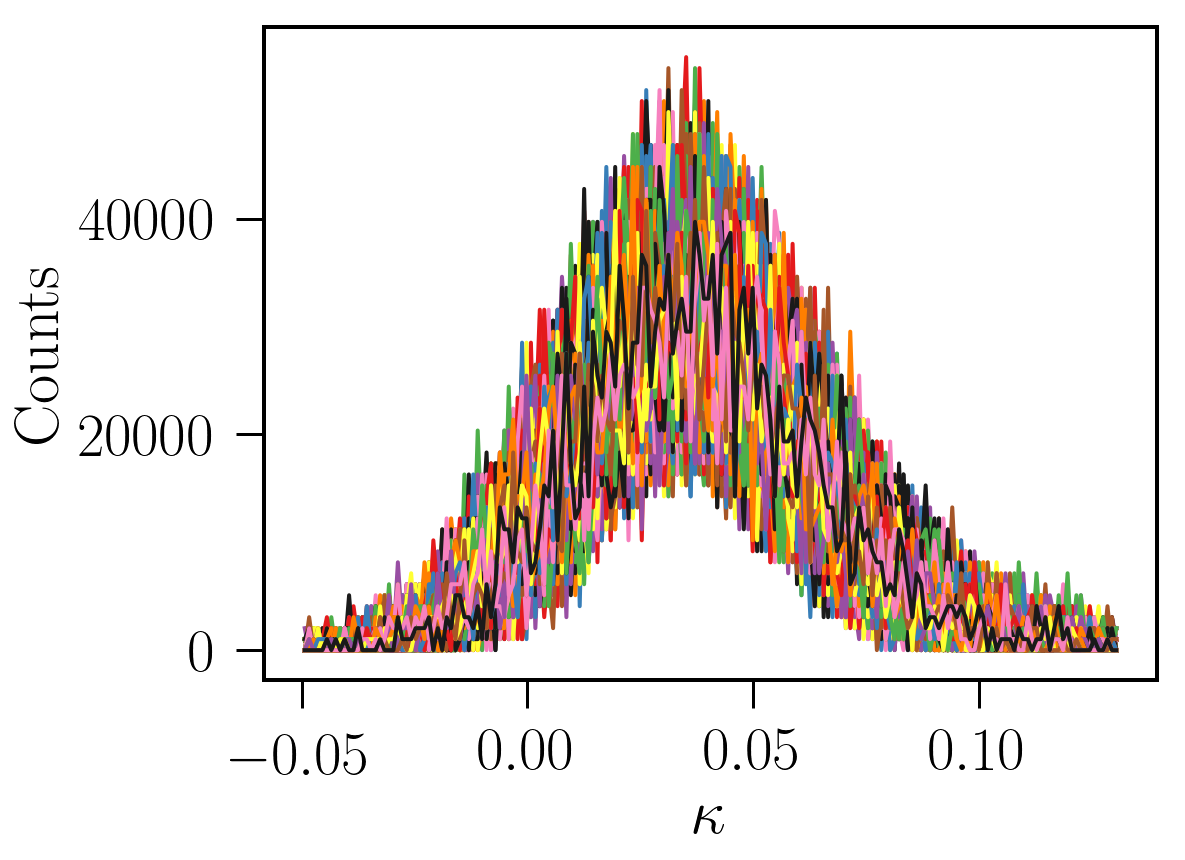

In [5]:
testell, testps, testkappa, testpc = get_PS_and_PC_arrays(table[0], 
                                      'powerspectrum_noisy', 'peakcounts_noisy')
plt.plot(testkappa, testpc.T)
plt.xlabel(r'$\kappa$');
plt.ylabel('Counts');

## 1.1. Computing the Covariance Matrix
We compute the covariance between each bin, correcting for bins and sky coverage. We correct for the bin number by scaling the inverse covariance aka Fisher matrix, where $p$ is the number of bins and $n$ is the number of realizations,
$$\hat{C}^{-1} = \frac{ n-p-2 }{ n-1 } \hat{C}_*^{-1} \text{ for } p < n-2$$

Sky fraction is corrected by multiplying the covariance by $12.25 / (\text{square degrees of sky})$, the maps were originally made with a sky for a smaller survey.

In [6]:
def compute_inverse_covariance(realizations, sky_coverage=2e4, verbose=False):

    cov = np.cov(realizations.T)

    nrealizations, nbins = realizations.shape
    bin_correction = (nrealizations - nbins - 2) / (nrealizations - 1)
    sky_correction = 12.25/sky_coverage
    
    if verbose: print('nr', nrealizations, 'nb', nbins, 
                      'bin', bin_correction, 'sky',sky_correction )

    # this 12.25/2e4 is from the LSST area divided by box, from Jia's email
    invcov = bin_correction * np.linalg.inv(cov * sky_correction)
    
    return invcov

## Plotting the Correlation Matrix (noisy)

nr 1000 nb 120 bin 0.8788788788788788 sky 0.0006125
nr 1000 nb 862 bin 0.13613613613613615 sky 0.0006125


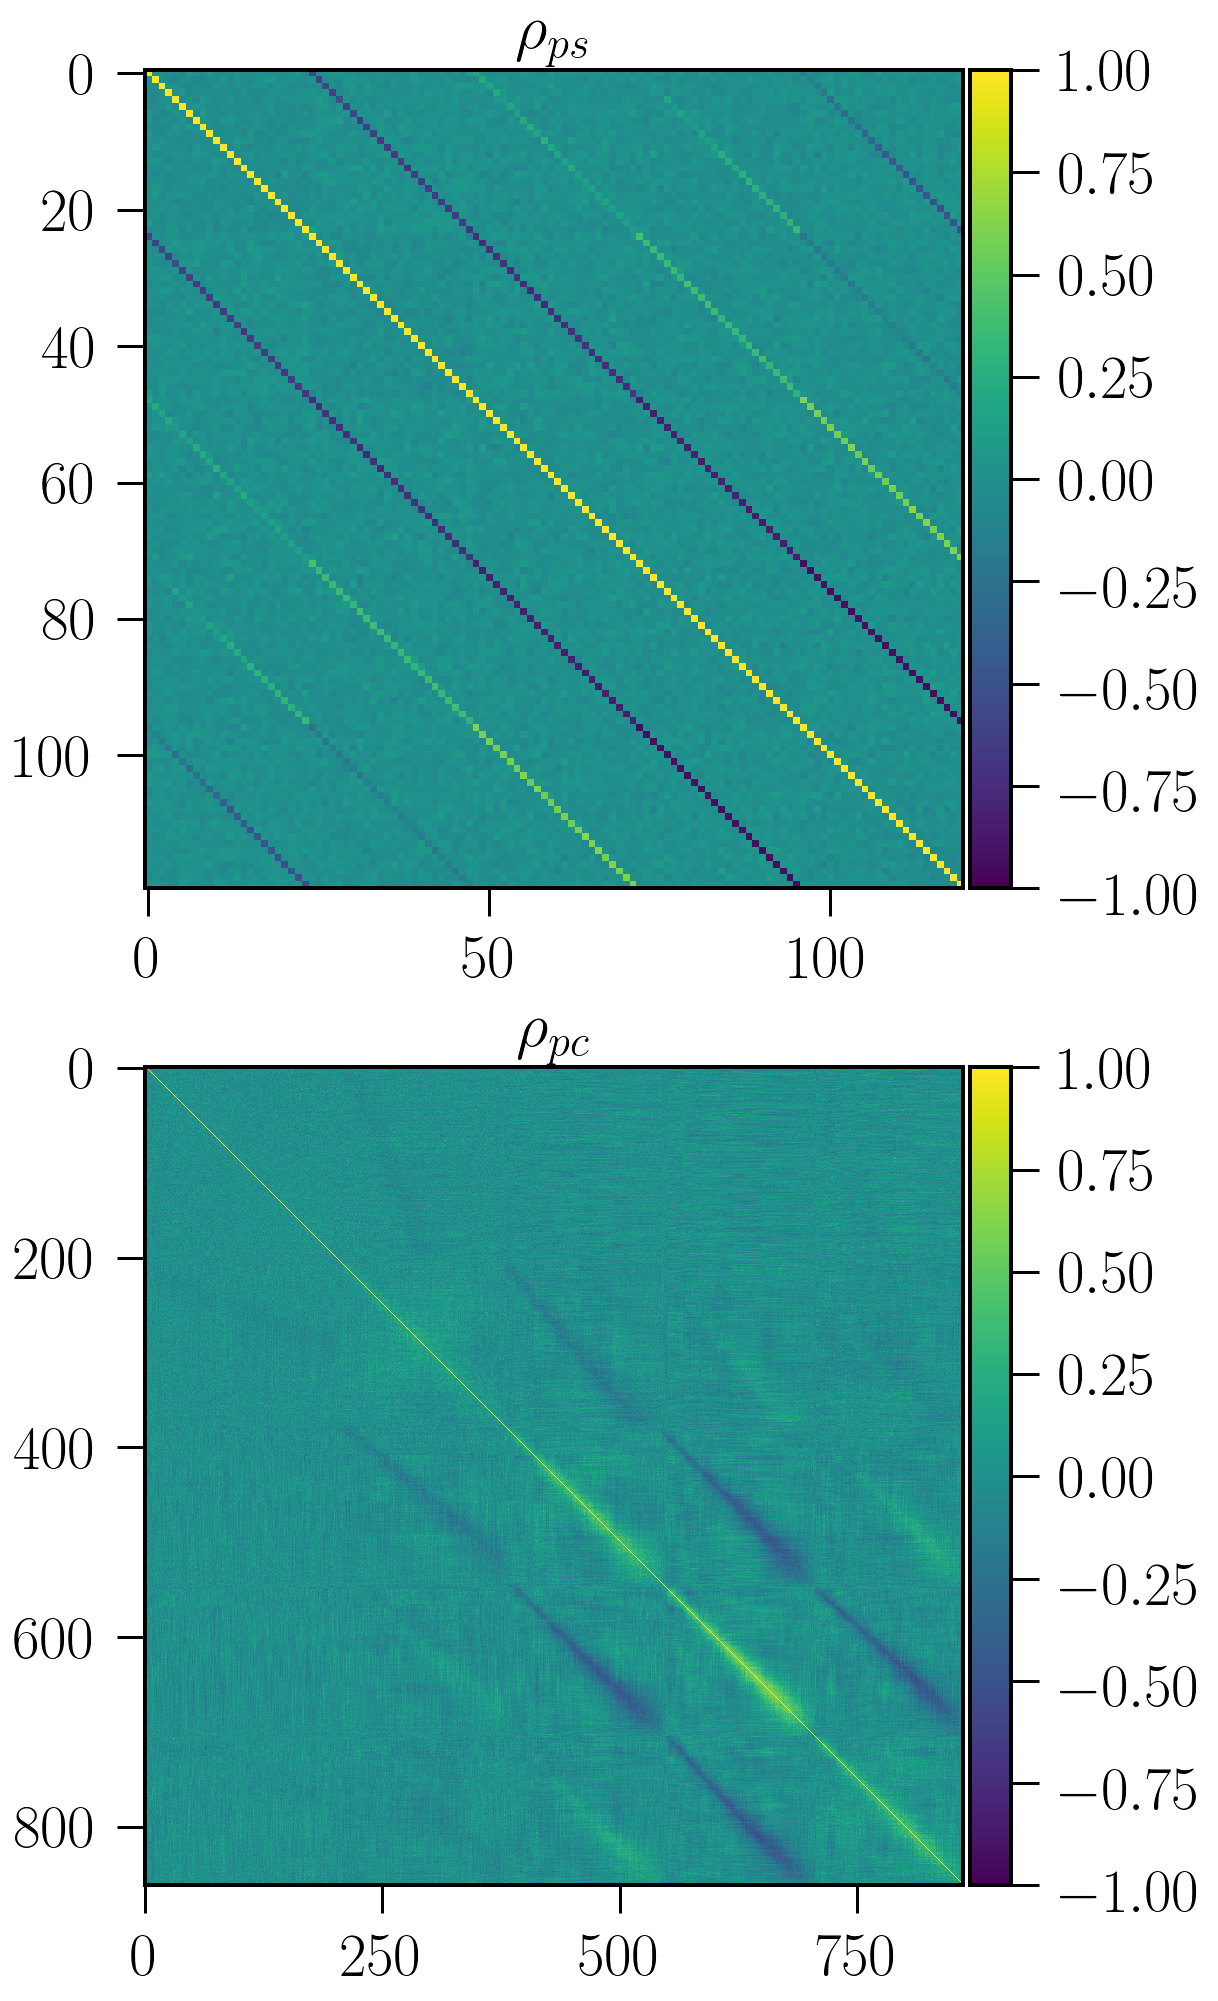

In [97]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

ps_dir = 'powerspectrum_noisy'
pc_dir = 'peakcounts_noisy'

# load in realizations for covariance computation
ell, ps_rs, kappa, pc_rs = get_PS_and_PC_arrays(table[1], 
                                               ps_dir, pc_dir,
                                               redshift_list=['05', '10', '15', '20', '25'],
                                               l_min_list=[200]*5,l_max_list=[5000]*5, 
                                               kappa_min_list=[-0.045]*5,kappa_max_list=[np.inf]*5)
cov_ps = compute_inverse_covariance(ps_rs, verbose=True)
cov_pc = compute_inverse_covariance(pc_rs, verbose=True)

fig, axes = plt.subplots(2,1,figsize=(8,14) )
D_ps = np.diag(1./np.sqrt(np.diag(cov_ps)))
cor_ps = np.dot(D_ps,  np.dot(cov_ps , D_ps))
mappable0 = axes[0].imshow(cor_ps, vmin=-1, vmax=1)

D_pc = np.diag(1./np.sqrt(np.diag(cov_pc)))
cor_pc = np.dot(D_pc,  np.dot(cov_pc , D_pc))
mappable1 = axes[1].imshow(cor_pc, vmin=-1, vmax=1)

divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(mappable0, cax=cax)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(mappable1, cax=cax)

axes[0].set_title(r'$\rho_{ps}$')
axes[1].set_title(r'$\rho_{pc}$')

plt.tight_layout()

## noiseless

nr 1000 nb 120 bin 0.8788788788788788 sky 0.0006125
nr 1000 nb 665 bin 0.3333333333333333 sky 0.0006125


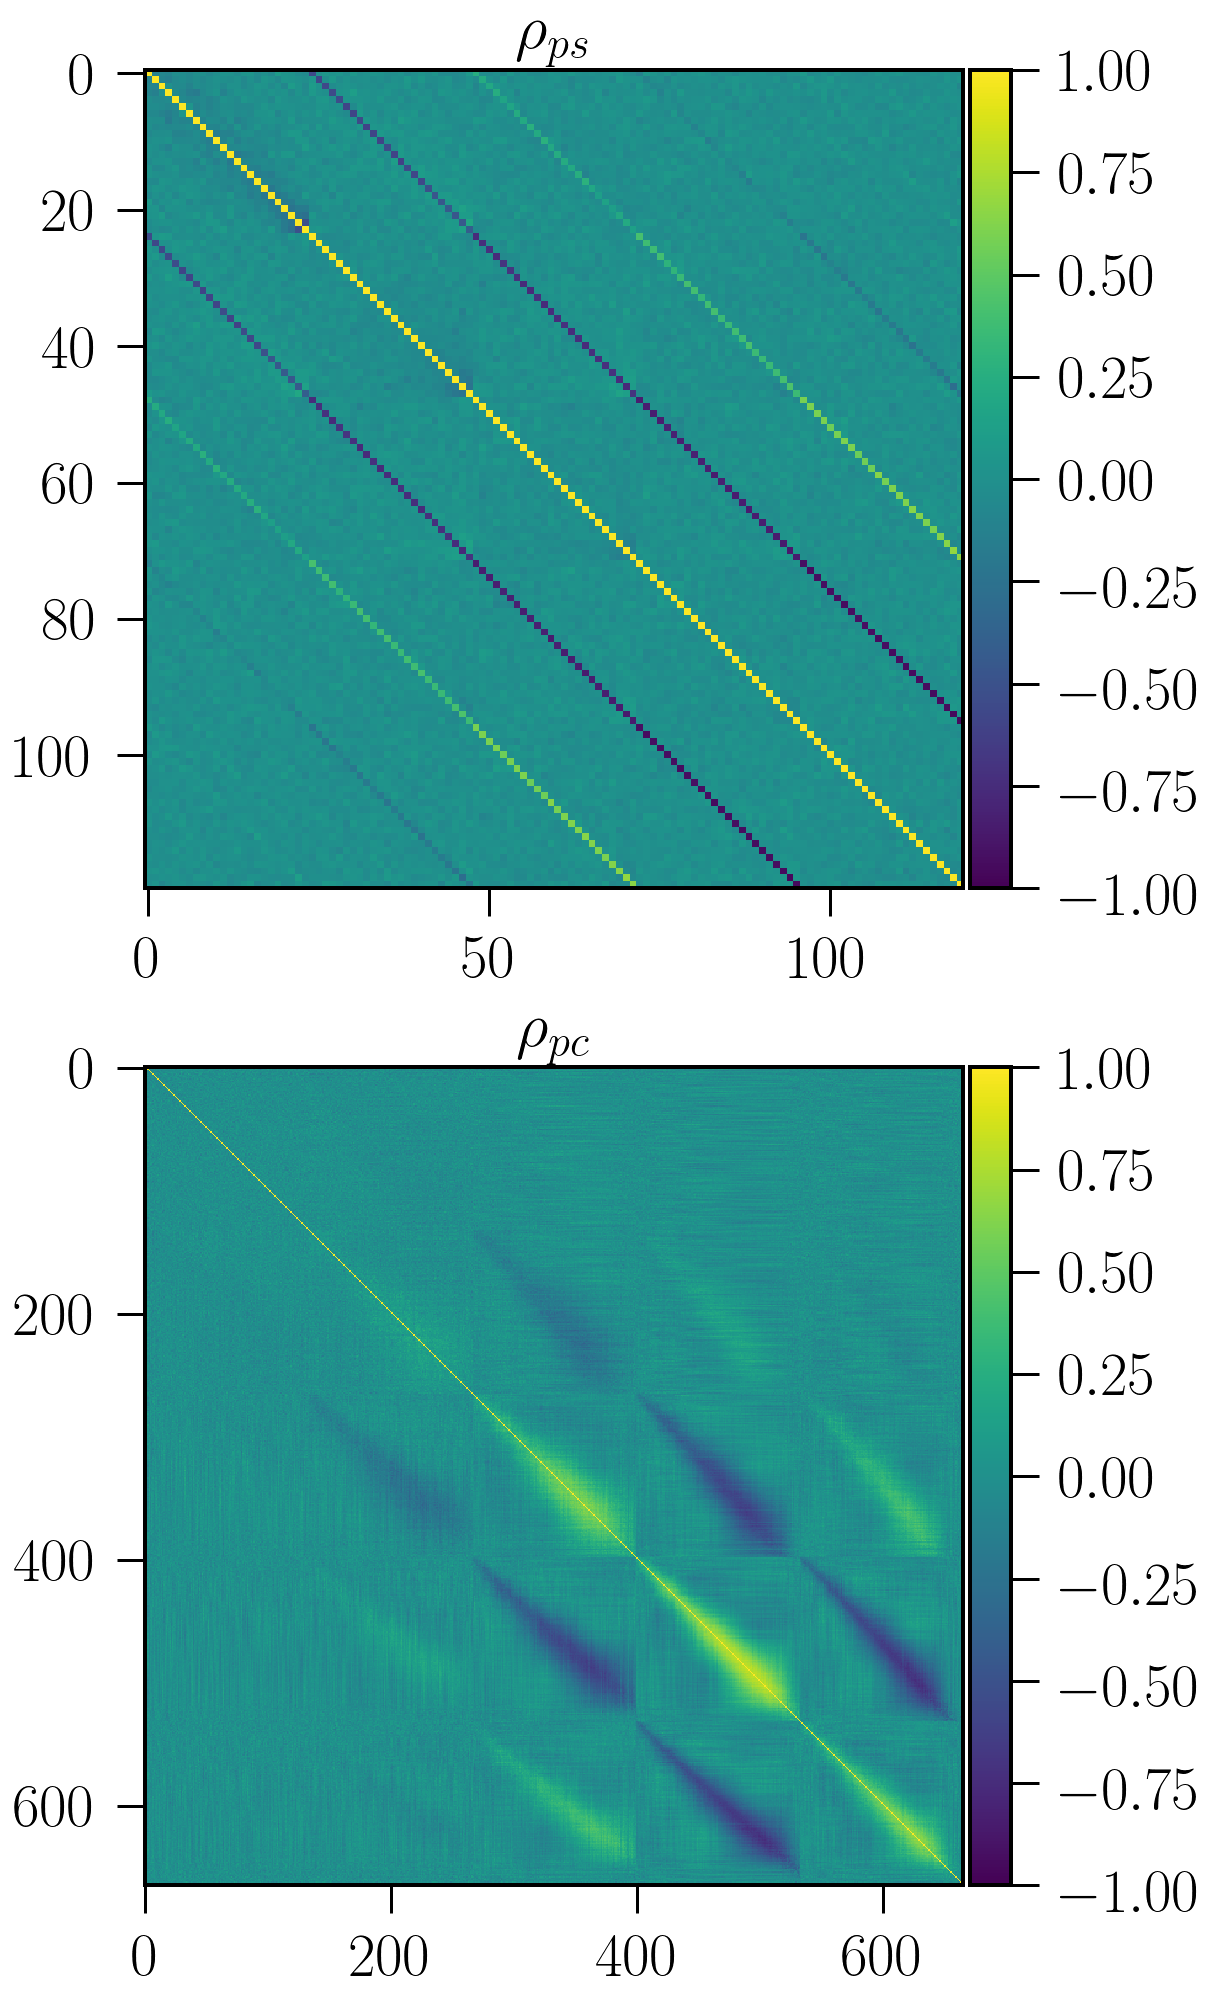

In [105]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

ps_dir = 'powerspectrum_noiseless'
pc_dir = 'peakcounts_noiseless'

# load in realizations for covariance computation
ell, ps_rs, kappa, pc_rs = get_PS_and_PC_arrays(table[1], 
                                               ps_dir, pc_dir,
                                               redshift_list=['05', '10', '15', '20', '25'],
                                               l_min_list=[200]*5,l_max_list=[5000]*5, 
                                               kappa_min_list=[-0.0]*5,kappa_max_list=[np.inf]*5)
cov_ps = compute_inverse_covariance(ps_rs, verbose=True)
cov_pc = compute_inverse_covariance(pc_rs, verbose=True)

fig, axes = plt.subplots(2,1,figsize=(8,14) )
D_ps = np.diag(1./np.sqrt(np.diag(cov_ps)))
cor_ps = np.dot(D_ps,  np.dot(cov_ps , D_ps))
mappable0 = axes[0].imshow(cor_ps, vmin=-1, vmax=1)

D_pc = np.diag(1./np.sqrt(np.diag(cov_pc)))
cor_pc = np.dot(D_pc,  np.dot(cov_pc , D_pc))
mappable1 = axes[1].imshow(cor_pc, vmin=-1, vmax=1)

divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(mappable0, cax=cax)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(mappable1, cax=cax)

axes[0].set_title(r'$\rho_{ps}$')
axes[1].set_title(r'$\rho_{pc}$')

plt.tight_layout()

## 1.2. Computing Mean Realizations
For each parameter combination in the table, we need to compute mean realization combinations.

In [7]:
def compute_mean_realizations(input_table, PS_directory, PC_directory,
                             redshift_list=['10'],
                             l_min_list=[200], 
                             l_max_list=[5000], 
                             kappa_min_list=[-0.05], 
                             kappa_max_list=[np.inf]):
    
    # we construct the means array by appending lists. This is slower for 
    # memory allocation reasons, but in my opinion makes for cleaner code.
    PS_means = []
    PC_means = []
    
    for row_index, row in enumerate(input_table):
        ell, ps, kappa, pc = get_PS_and_PC_arrays(row, PS_directory, PC_directory,
                                                 redshift_list=redshift_list,
                                                 l_min_list=l_min_list, 
                                                 l_max_list=l_max_list, 
                                                 kappa_min_list=kappa_min_list, 
                                                 kappa_max_list=kappa_max_list)
        PS_means.append( np.mean(ps, axis=0) )
        PC_means.append( np.mean(pc, axis=0) )
        
    return np.array(PS_means), np.array(PC_means)

## 1.3. Construct Interpolators
Functions for constructing interpolators.

Initialize the class with two key inputs,
1. obs_arr has dimension (Npoints, Nbin), where Npoints = # of 
    cosmological models (=100 here), 
    and Nbins is the number of bins
2. cosmo_params has dimension (Nparams, Npoints)

In [8]:
from scipy import interpolate

class Interp:

    def __init__(self,obsarr, cosmo_params, invcov, fiducial_model,
                 function='multiquadric', smooth=0.0):
        
        cosmo_params = np.array(cosmo_params)
        self.invcov = invcov
        self.fid = fiducial_model
        
        
        # create a list of Rbf for each independent mode
        spline_interps = [ interpolate.Rbf(*cosmo_params, model, 
                                           function=function, smooth=smooth)
                          for model in obsarr.T ]
        
        # create a function that applies interpolator to the parameters given, for each mode
        self.interp_func = lambda params: np.array([ii(*params) for ii in spline_interps])

    def P(self, parameter_input):
        dm = self.fid - self.interp_func( parameter_input ) # d - mu
        return np.exp( -0.5 * np.dot(dm.T,np.dot(self.invcov,dm)) )
        


# 1.4. An Example Cube Calculation

In [9]:
%%time
ps_dir = 'powerspectrum_noisy'
pc_dir = 'peakcounts_noisy'

# load in realizations for covariance computation
ell, ps_rs, kappa, pc_rs = get_PS_and_PC_arrays(table[1], 
                                               ps_dir, pc_dir,
                                               redshift_list=['05', '10', '15', '20', '25'],
                                               l_min_list=[200]*5,l_max_list=[5000]*5, 
                                               kappa_min_list=[-0.045]*5,kappa_max_list=[np.inf]*5)
# get means of realizations for each cosmology
ps_mean, pc_mean = compute_mean_realizations(table, ps_dir, pc_dir, redshift_list=['05', '10', '15', '20', '25'],
                                               l_min_list=[200]*5,l_max_list=[5000]*5, 
                                               kappa_min_list=[-0.045]*5,kappa_max_list=[np.inf]*5)
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])
cov = compute_inverse_covariance(ps_rs, verbose=True)


# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=cov,
                        fiducial_model=ps_mean[1])
nres = 20
x = np.linspace(0.1 - 0.025, 0.1 + 0.025, nres) # M_nu
y = np.linspace(0.3 - 0.005, 0.3 + 0.005, nres) # omega_m
z = np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PS.npy', cube)
np.save( 'cubes/5z_PS_xyz.npy', np.array([x,y,z]) )

In [18]:
# plt.plot( z, np.sum(np.sum(cube, axis=0), axis=0) )

# 1.5. Compute Cubes for Paper
We write a utility function from the above, and then compute the cubes used in the paper.

In [106]:
def easy_cube_generate(name, ps_dir, pc_dir, xyz_PS, xyz_PC,
                       redshift_list=['10'],
                       l_min_list=[200],l_max_list=[5000], 
                       kappa_min_list=[-0.045],kappa_max_list=[np.inf], nprocs=16, use_PS=True, use_PC=True):

    # load in realizations for covariance computation
    ell, ps_rs, kappa, pc_rs = get_PS_and_PC_arrays(table[1], 
                                                   ps_dir, pc_dir, 
                                                   redshift_list=redshift_list,
                                                   l_min_list=l_min_list,
                                                   l_max_list=l_max_list,
                                                   kappa_min_list=kappa_min_list, 
                                                   kappa_max_list=kappa_max_list)
    # get means of realizations for each cosmology
    ps_mean, pc_mean = compute_mean_realizations(table, ps_dir, pc_dir, 
                                                   redshift_list=redshift_list,
                                                   l_min_list=l_min_list,
                                                   l_max_list=l_max_list,
                                                   kappa_min_list=kappa_min_list, 
                                                   kappa_max_list=kappa_max_list)
    params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

    if use_PS:
        # construct interpolator for PS
        interp_ps = Interp(obsarr=ps_mean,
                                cosmo_params=params,
                                invcov=compute_inverse_covariance(ps_rs),
                                fiducial_model=ps_mean[1])
        x, y, z = xyz_PS
        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
        input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

        p = mp.Pool(nprocs)  # Processing Pool with 16 cores (adjust for your own machine)
        cube = np.array(p.map(interp_ps.P, input_param_list ))
        cube = cube.reshape(X.shape)
        p.close()
        np.save('cubes/' + name + '_PS.npy', cube)
        np.save('cubes/' + name + '_PS_xyz.npy', np.array([x,y,z]) )
        
    if use_PC:
        # construct interpolator for PC
        interp_pc = Interp(obsarr=pc_mean,
                                cosmo_params=params,
                                invcov=compute_inverse_covariance(pc_rs),
                                fiducial_model=pc_mean[1])

        x, y, z = xyz_PC
        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
        input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

        p = mp.Pool(nprocs)  # Processing Pool with 16 cores (adjust for your own machine)
        cube = np.array(p.map(interp_pc.P, input_param_list ))
        cube = cube.reshape(X.shape)
        p.close()
        np.save('cubes/' + name + '_PC.npy', cube)
        np.save( 'cubes/' + name + '_PC_xyz.npy', np.array([x,y,z]) )


Run the following cells to generate almost every likelihood cube in the paper.

In [108]:
nres=50

In [13]:
%%time
easy_cube_generate(name='ngal40',
                   ps_dir='powerspectrum_ngal40',
                   pc_dir='peakcounts_ngal40',
                   xyz_PS=[
                       np.linspace(0.1 - 0.04, 0.1 + 0.13, nres), # M_nu
                       np.linspace(0.3 - 0.012, 0.3 + 0.01, nres), # omega_m
                       np.linspace(0.8295 - 0.012, 0.8295 + 0.016, nres)], # sigma_8
                   xyz_PC=[
                       np.linspace(0.1 - 0.01, 0.1 + 0.01, nres), # M_nu
                       np.linspace(0.3 - 0.003, 0.3 + 0.003, nres), # omega_m
                       np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres)], # sigma_8
                    redshift_list=['10']
                  )

CPU times: user 1min 3s, sys: 2.48 s, total: 1min 5s
Wall time: 14min 5s


In [110]:
%%time
easy_cube_generate(name='5z_2000',
                   ps_dir='powerspectrum_noisy',
                   pc_dir='peakcounts_noisy',
                   xyz_PS=[
                       np.linspace(0.1 - 0.04, 0.1 + 0.04, nres), # M_nu
                       np.linspace(0.3 - 0.008, 0.3 + 0.008, nres), # omega_m
                       np.linspace(0.8295 - 0.008, 0.8295 + 0.008, nres)], # sigma_8
                   xyz_PC=[ # NOTE: PC NOT USED HERE
                       np.linspace(0.1 - 0.01, 0.1 + 0.01, nres), # M_nu
                       np.linspace(0.3 - 0.003, 0.3 + 0.003, nres), # omega_m
                       np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres)], # sigma_8
                    redshift_list=['05', '10', '15', '20', '25'],
                    l_min_list=[200]*5,l_max_list=[2000]*5, 
                       kappa_min_list=[-0.045]*5,kappa_max_list=[np.inf]*5,
                   use_PC=False)

CPU times: user 31.5 s, sys: 1.44 s, total: 32.9 s
Wall time: 1min 25s


In [ ]:
%%time

easy_cube_generate(name='5z_5000',
                   ps_dir='powerspectrum_noisy',
                   pc_dir='peakcounts_noisy',
                   xyz_PS=[
                       np.linspace(0.1 - 0.025, 0.1 + 0.025, nres), # M_nu
                       np.linspace(0.3 - 0.005, 0.3 + 0.005, nres), # omega_m
                       np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres)], # sigma_8
                   xyz_PC=[
                       np.linspace(0.1 - 0.01, 0.1 + 0.01, nres), # M_nu
                       np.linspace(0.3 - 0.003, 0.3 + 0.003, nres), # omega_m
                       np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres)], # sigma_8
                    redshift_list=['05', '10', '15', '20', '25'],
                    l_min_list=[200]*5,l_max_list=[5000]*5, 
                       kappa_min_list=[-0.045]*5,kappa_max_list=[np.inf]*5,
                   use_PC=False)

In [ ]:
%%time
easy_cube_generate(name='5z_10000',
                   ps_dir='powerspectrum_noisy',
                   pc_dir='peakcounts_noisy',
                   xyz_PS=[
                       np.linspace(0.1 - 0.025, 0.1 + 0.025, nres), # M_nu
                       np.linspace(0.3 - 0.005, 0.3 + 0.005, nres), # omega_m
                       np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres)], # sigma_8
                   xyz_PC=[
                       np.linspace(0.1 - 0.01, 0.1 + 0.01, nres), # M_nu
                       np.linspace(0.3 - 0.003, 0.3 + 0.003, nres), # omega_m
                       np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres)], # sigma_8
                    redshift_list=['05', '10', '15', '20', '25'],
                    l_min_list=[200]*5,l_max_list=[10000]*5, 
                       kappa_min_list=[-0.045]*5,kappa_max_list=[np.inf]*5,
                   use_PC=False)

In [ ]:
%%time
easy_cube_generate(name='5z_CMB',
                   ps_dir='powerspectrum_noisy',
                   pc_dir='peakcounts_noisy',
                   xyz_PS=[
                       np.linspace(0.1 - 0.025, 0.1 + 0.025, nres), # M_nu
                       np.linspace(0.3 - 0.005, 0.3 + 0.005, nres), # omega_m
                       np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres)], # sigma_8
                   xyz_PC=[
                       np.linspace(0.1 - 0.01, 0.1 + 0.01, nres), # M_nu
                       np.linspace(0.3 - 0.003, 0.3 + 0.003, nres), # omega_m
                       np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres)], # sigma_8
                    redshift_list=['05', '10', '15', '20', '25', '11000'],
                    l_min_list=[200]*5 + [360],l_max_list=[5000]*6, 
                       kappa_min_list=[-0.045]*6,kappa_max_list=[np.inf]*5 + [0.2]
                  )


In [ ]:
%%time
easy_cube_generate(name='ngal40',
                   ps_dir='powerspectrum_noiseless',
                   pc_dir='peakcounts_noiseless',
                   xyz_PS=[
                       np.linspace(0.1 - 0.04, 0.1 + 0.13, nres), # M_nu
                       np.linspace(0.3 - 0.012, 0.3 + 0.01, nres), # omega_m
                       np.linspace(0.8295 - 0.012, 0.8295 + 0.016, nres)], # sigma_8
                   xyz_PC=[
                       np.linspace(0.1 - 0.01, 0.1 + 0.01, nres), # M_nu
                       np.linspace(0.3 - 0.003, 0.3 + 0.003, nres), # omega_m
                       np.linspace(0.8295 - 0.005, 0.8295 + 0.005, nres)], # sigma_8
                    redshift_list=['10']
                  )

In [52]:
table.colnames

['Model', 'M_nu(eV)', 'Omega_m', '10^9*A_s', 'sigma_8(derived)', 'PS', 'PC']

# Tests and Misc Figures

How affected are our forecasts affected by the parameter distribution? Let's investigate for the "5 galaxy redshift" likelihood cubes.

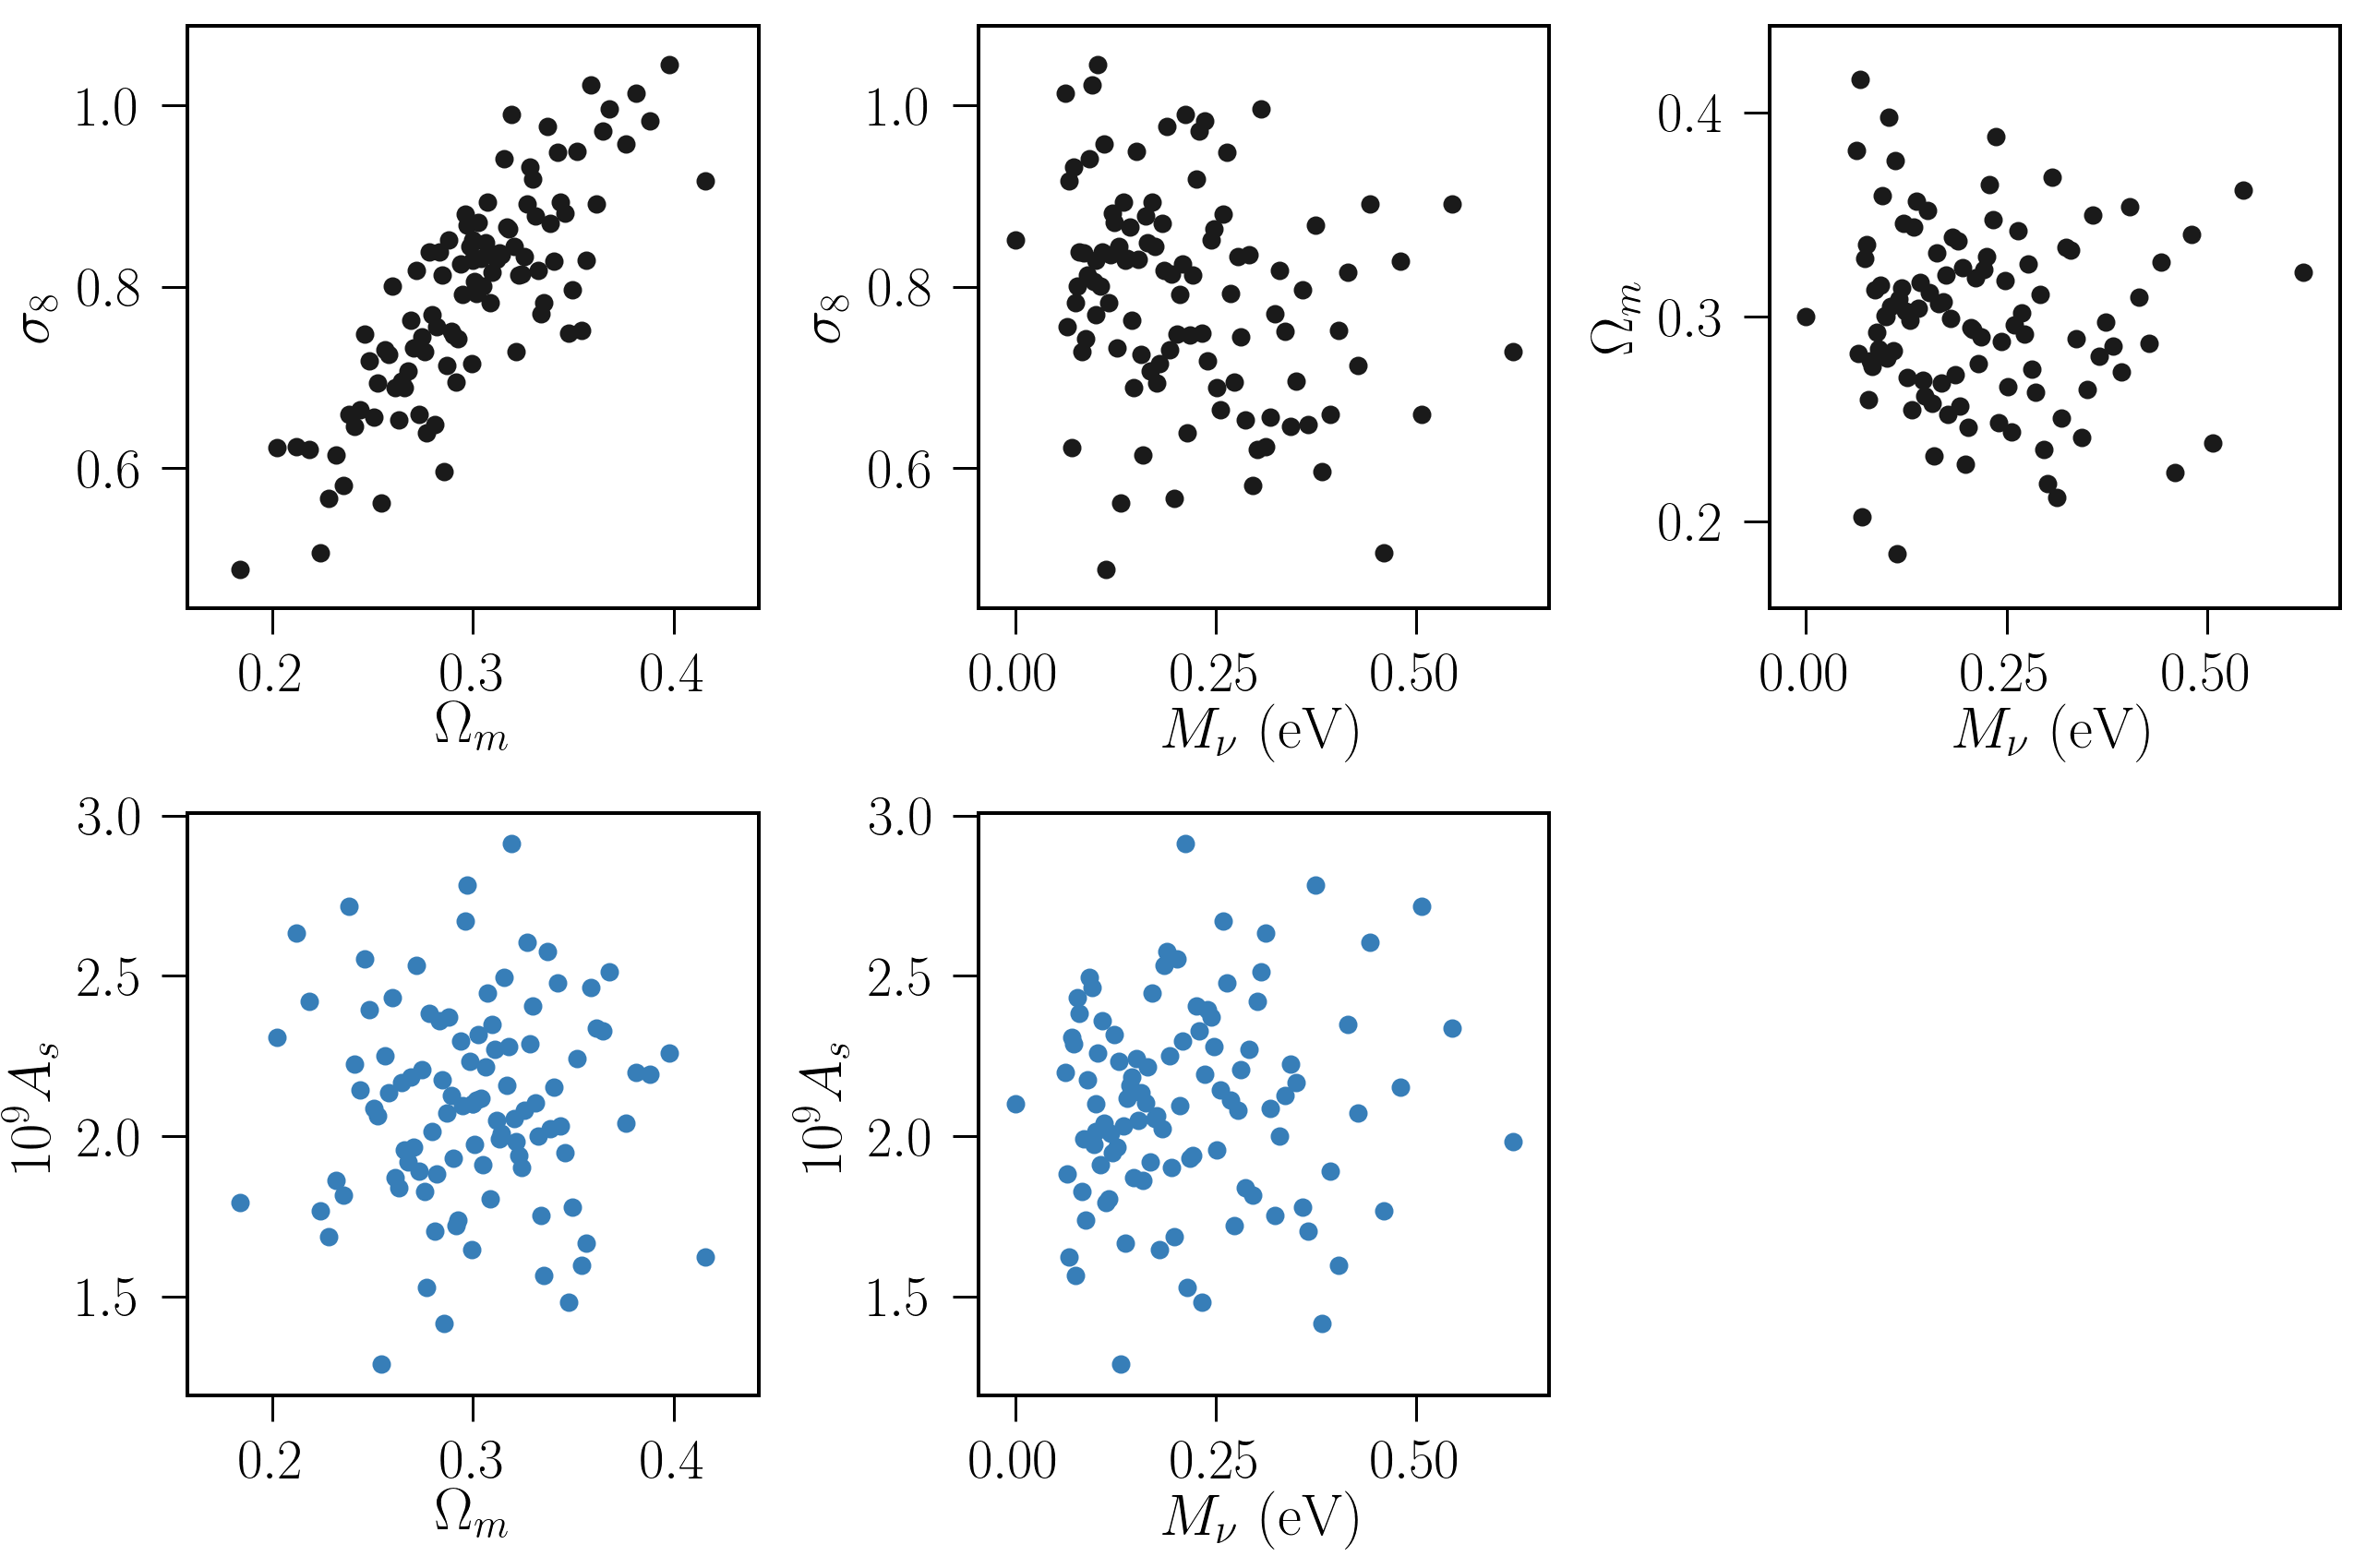

In [63]:
fig, axes = plt.subplots(2,3,figsize=(18,12))

axes[0,0].scatter( table['Omega_m'], table['sigma_8(derived)'], color=default_color_list[0]  )
axes[0,1].scatter( table['M_nu(eV)'], table['sigma_8(derived)'], color=default_color_list[0] )
axes[0,2].scatter( table['M_nu(eV)'], table['Omega_m'], color=default_color_list[0] )
axes[0,0].set_xlabel(r'$\Omega_m$'); axes[0,0].set_ylabel(r'$\sigma_8$')
axes[0,1].set_xlabel(r'$M_{\nu}$ (eV)'); axes[0,1].set_ylabel(r'$\sigma_8$')
axes[0,2].set_xlabel(r'$M_{\nu}$ (eV)'); axes[0,2].set_ylabel(r'$\Omega_m$')

axes[1,0].scatter( table['Omega_m'], table['10^9*A_s'], color=default_color_list[2]  )
axes[1,1].scatter( table['M_nu(eV)'], table['10^9*A_s'], color=default_color_list[2] )
# axes[1,2].scatter( table['M_nu(eV)'], table['Omega_m'], color=default_color_list[2] )
axes[1,0].set_xlabel(r'$\Omega_m$'); axes[1,0].set_ylabel(r'$10^9 A_s$')
axes[1,1].set_xlabel(r'$M_{\nu}$ (eV)'); axes[1,1].set_ylabel(r'$10^9 A_s$')
# axes[1,2].set_xlabel(r'$M_{\nu}$ (eV)'); axes[1,2].set_ylabel(r'$\Omega_m$')

axes[1,2].set_visible(False)

# axes[0,1].scatter( table['M_nu(eV)'], table['Omega_m']  )
plt.tight_layout()

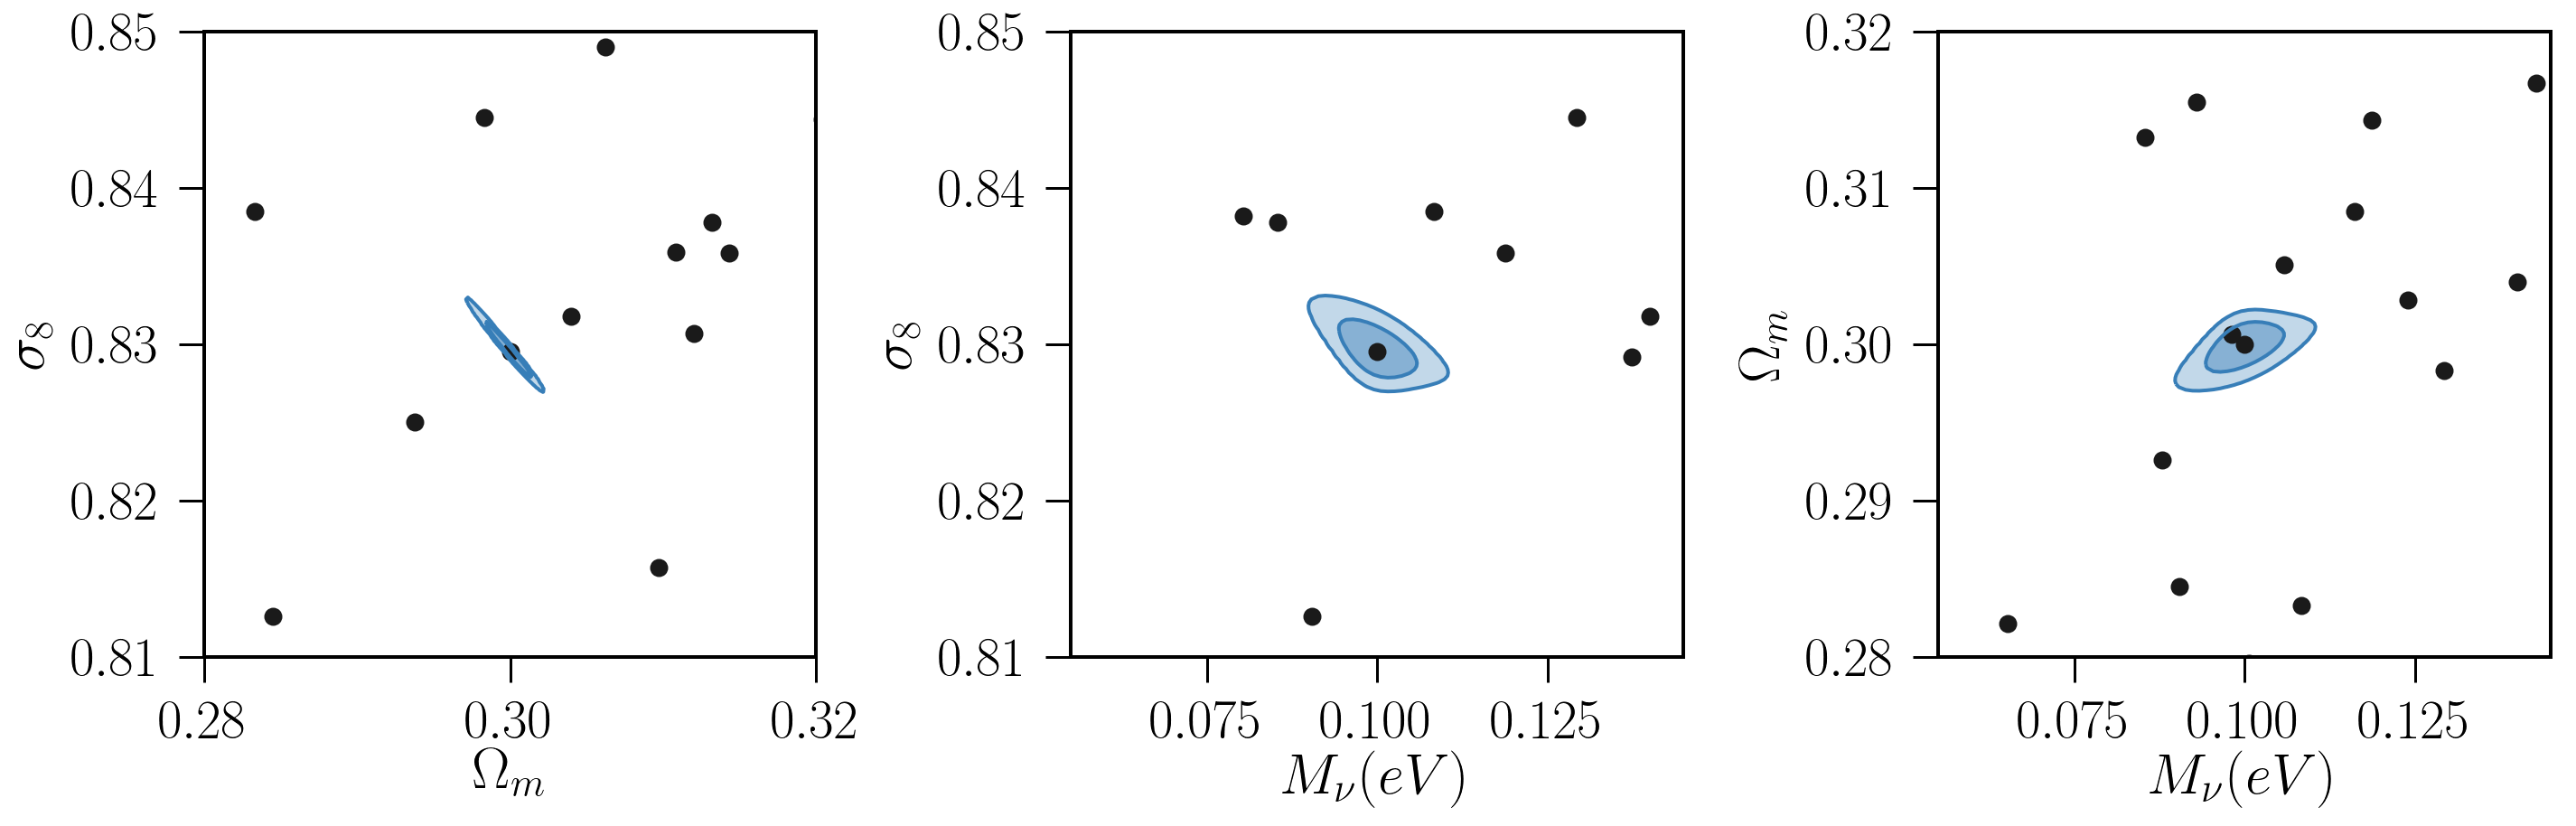

In [57]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# PRECOMPUTED CUBES! NO NEED TO REDO CALCS
x,y,z = np.load(  'cubes/5z_CMB_PS_xyz.npy' )
c2 = np.load( 'cubes/5z_CMB_PS.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[2],
                       input_label='new')

axes[0].scatter( table['Omega_m'], table['sigma_8(derived)']  )
axes[0].set_xlim(0.28,0.32); axes[0].set_ylim(0.81,0.85);

axes[1].scatter( table['M_nu(eV)'], table['sigma_8(derived)']  )
axes[1].set_xlim((0.055,0.145)); axes[1].set_ylim(0.81,0.85);

axes[2].scatter( table['M_nu(eV)'], table['Omega_m']  )
axes[2].set_xlim(0.055,0.145); axes[2].set_ylim(0.28,0.32);

plt.tight_layout()